# Relevant simulations for finding a viable trading strategy

Starting from the [Raposa blog post](https://raposa.trade/blog/how-to-improve-your-trading-system-with-the-kelly-criterion/) I want to reproduce the important results and extend upon them.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from util_kelly import simulate_kelly_strategy, StockMarketData, plot_strategy

The reference timeframe is the same as in the blog post.

In [2]:
DATE_MIN_BLOG = pd.Timestamp(1993, 1, 1).to_pydatetime()
DATE_MAX_BLOG = pd.Timestamp(2020, 12, 31).to_pydatetime()
PATH_TO_CSV = 'data/spx_day.csv'
simulation_data = StockMarketData(PATH_TO_CSV, parse_dates=['Date'], infer_datetime_format=True, index_col=0)
simulation_data.restrict_date(start_date=DATE_MIN_BLOG, end_date=DATE_MAX_BLOG)

First we compare a simple unconstrained Kelly sizing strategy with the baseline buy and hold strategy.

/home/pafrank/anaconda3/envs/trading-sp500/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


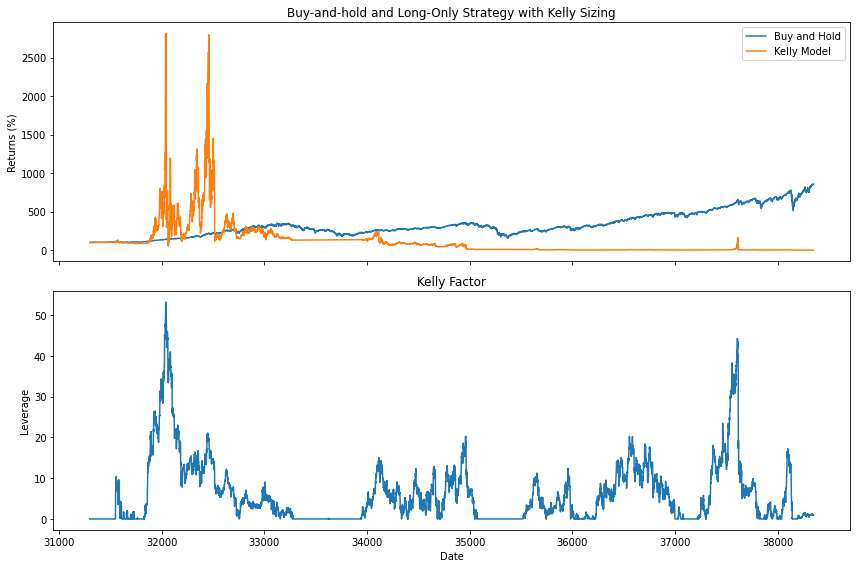

In [3]:
# as in blog post
k = simulate_kelly_strategy(simulation_data.get_data(), rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=252, min_kelly=0, max_kelly=100, kelly_fraction=1.0)

fig, ax = plt.subplots(2, figsize=(12, 8), sharex=True)
ax[0].plot(np.exp(k['cum_returns']) * 100, label='Buy and Hold')
ax[0].plot(np.exp(k['strategy_cum_returns']) * 100, label='Kelly Model')
ax[0].set_ylabel('Returns (%)')
ax[0].set_title('Buy-and-hold and Long-Only Strategy with Kelly Sizing')
ax[0].legend()
ax[1].plot(k['kelly_factor'])
ax[1].set_ylabel('Leverage')
ax[1].set_xlabel('Date')
ax[1].set_title('Kelly Factor')
plt.tight_layout()
plt.show()

The model fails spectacularly! Notice how Kelly Factor - that is the leverage of our position - blows up. This can result in astronomical gains if we we get lucky, as can be seen around day 32000. On the other hand if the asset moves down during a period of high leverage, we can get trapped in a liquidity crisis. This happens around day 34000. 

Lets try to improve the models robustness by constraining the maximum Kelly factor.

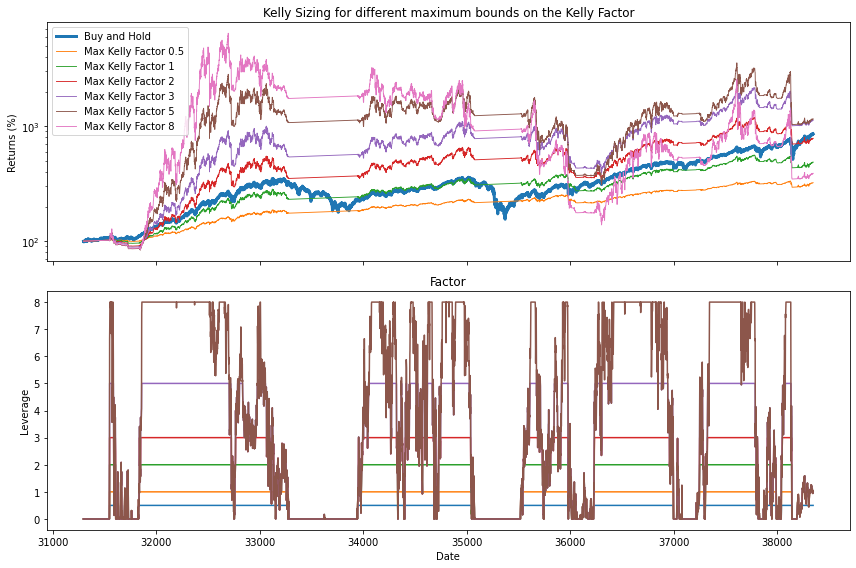

In [4]:
max_kelly = [0.5, 1, 2, 3, 5, 8]
max_kelly_results = pd.DataFrame()

for i, factor in enumerate(max_kelly):
    df = simulate_kelly_strategy(simulation_data.get_data(), rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=252, min_kelly=0, max_kelly=factor)
    max_kelly_results[f"kelly_factor_{i}"] = df["kelly_factor"]
    max_kelly_results[f"strategy_cum_returns_{i}"] = df["strategy_cum_returns"]
    if i == 0:
        max_kelly_results["cum_returns"] = df["cum_returns"]

plot_strategy(max_kelly_results, max_kelly, label_return='Max Kelly Factor', \
    title_return='Kelly Sizing for different maximum bounds on the Kelly Factor', logplot=True)

We see that models that allow for higher leverage are generally more successful. Note that models with maximum Kelly Factor lower than 1.0 are at no time leveraged and perform worse than buy-and-hold at almost all times. On the other hand models with maximum Kelly Factor higher than 1.0 are leveraged and generally perform better than buy-and-hold except for periods with a sudden downturn.

The Kelly strategy tends to loose a lot of value suddenly turns down. Let's try to mitigate this by (1) only betting a fraction of the Kelly factor or (2) by shrinking the estimation window for the kelly factor esimation.

(1) use a fraction of the Kelly factor for the bet size. Let's also bound the maximum Kelly factor by 15 or by 10.

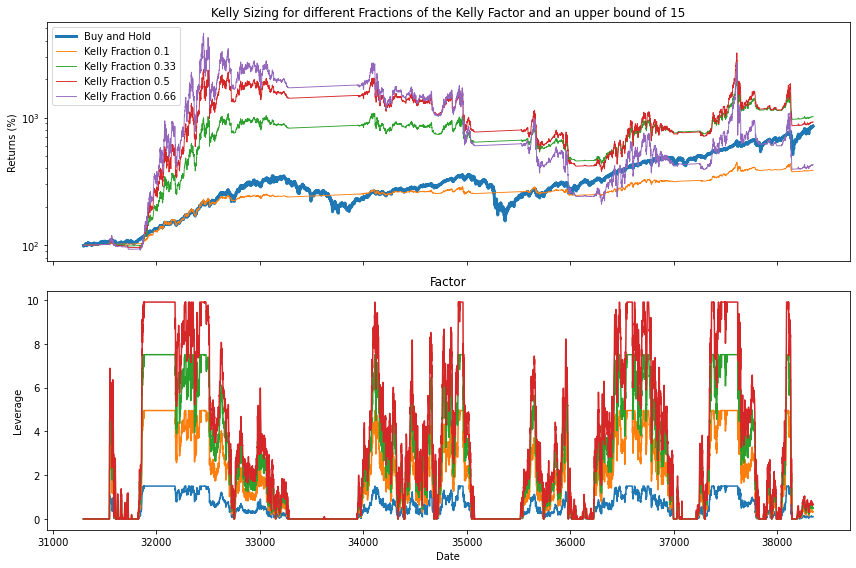

In [5]:
kelly_fraction = [0.1, 0.33, 0.5, 0.66]
kelly_fraction_results = pd.DataFrame()

for i, factor in enumerate(kelly_fraction):
    df = simulate_kelly_strategy(simulation_data.get_data(), rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=252, min_kelly=0, max_kelly=15, kelly_fraction=factor)
    kelly_fraction_results[f"kelly_factor_{i}"] = df["kelly_fraction"]
    kelly_fraction_results[f"strategy_cum_returns_{i}"] = df["strategy_cum_returns"]
    if i == 0:
        kelly_fraction_results["cum_returns"] = df["cum_returns"]

plot_strategy(kelly_fraction_results, kelly_fraction, label_return='Kelly Fraction', \
    title_return='Kelly Sizing for different Fractions of the Kelly Factor and an upper bound of 15', logplot=True)


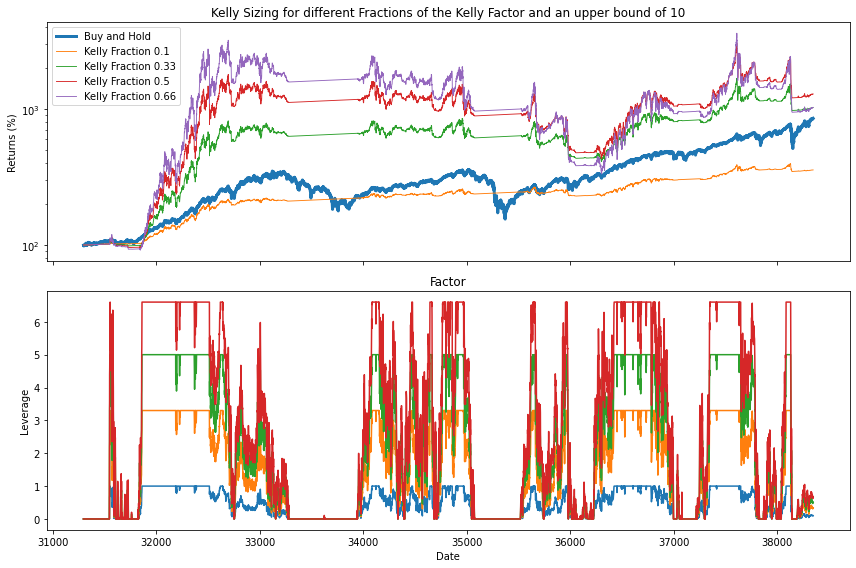

In [6]:
kelly_fraction = [0.1, 0.33, 0.5, 0.66]
kelly_fraction_results = pd.DataFrame()

for i, factor in enumerate(kelly_fraction):
    df = simulate_kelly_strategy(simulation_data.get_data(), rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=252, min_kelly=0, max_kelly=10, kelly_fraction=factor)
    kelly_fraction_results[f"kelly_factor_{i}"] = df["kelly_fraction"]
    kelly_fraction_results[f"strategy_cum_returns_{i}"] = df["strategy_cum_returns"]
    if i == 0:
        kelly_fraction_results["cum_returns"] = df["cum_returns"]

plot_strategy(kelly_fraction_results, kelly_fraction, label_return='Kelly Fraction', \
    title_return='Kelly Sizing for different Fractions of the Kelly Factor and an upper bound of 10', logplot=True)

There seems to be a sweet spot for a maximum effective Kelly factor in the range of [3,6]. That is the product (maximum Kelly factor) * (Kelly factor fraction) is in that range.

(2) let's shrink the estimation window for the Kelly factor estimation instead.

/home/pafrank/anaconda3/envs/trading-sp500/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


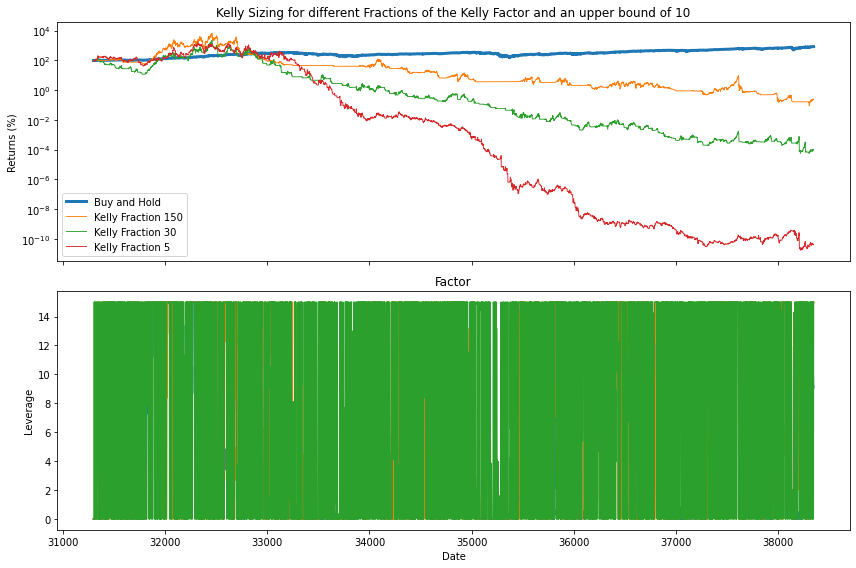

In [7]:
estimation_window = [150, 30, 5]
estimation_window_results = pd.DataFrame()

for i, factor in enumerate(estimation_window):
    df = simulate_kelly_strategy(simulation_data.get_data(), rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=factor, min_kelly=0, max_kelly=15, kelly_fraction=1.0)
    estimation_window_results[f"kelly_factor_{i}"] = df["kelly_fraction"]
    estimation_window_results[f"strategy_cum_returns_{i}"] = df["strategy_cum_returns"]
    if i == 0:
        estimation_window_results["cum_returns"] = df["cum_returns"]

plot_strategy(estimation_window_results, estimation_window, label_return='Kelly Fraction', \
    title_return='Kelly Sizing for different Fractions of the Kelly Factor and an upper bound of 10', logplot=True)

That didn't help! So let's settle on controlling the leverage and the fractional Kelly factor for betting.

What happens when we increase the window size to estimate the Kelly factor of different timeframes?

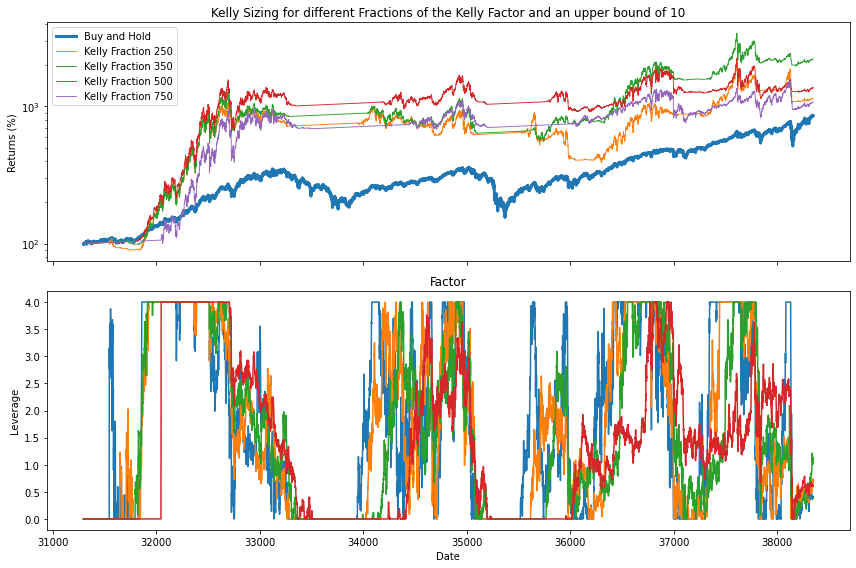

In [9]:
estimation_window = [250, 350, 500, 750]
estimation_window_results = pd.DataFrame()

for i, factor in enumerate(estimation_window):
    df = simulate_kelly_strategy(simulation_data.get_data(), rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=factor, min_kelly=0, max_kelly=10, kelly_fraction=0.4)
    estimation_window_results[f"kelly_factor_{i}"] = df["kelly_fraction"]
    estimation_window_results[f"strategy_cum_returns_{i}"] = df["strategy_cum_returns"]
    if i == 0:
        estimation_window_results["cum_returns"] = df["cum_returns"]

plot_strategy(estimation_window_results, estimation_window, label_return='Kelly Fraction', \
    title_return='Kelly Sizing for different Fractions of the Kelly Factor and an upper bound of 10', logplot=True)

Great, there seems to be a sweet spot around 350 timesteps, in this case trading days, which significantly increases the returns over the baseline buy and hold strategy.

Our strategy requires daily rebalancing of cash and assets. What happens if we can only afford to rebalance less frequently?

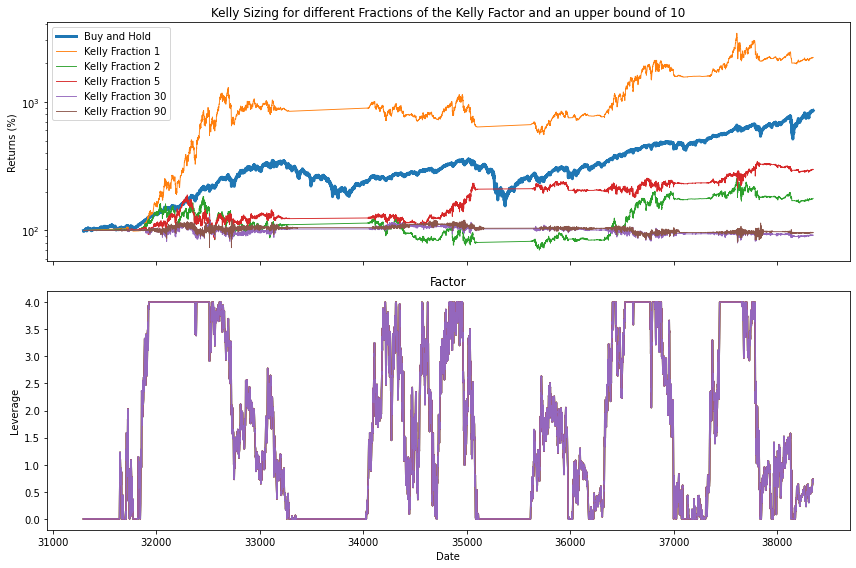

In [13]:
rebalancing = [1, 2, 5, 30, 90]
rebalancing_results = pd.DataFrame()

for i, factor in enumerate(rebalancing):
    df = simulate_kelly_strategy(simulation_data.get_data(), rebalancing_interval=factor, annual_risk_free_rate=0.02,\
     window=350, min_kelly=0, max_kelly=10, kelly_fraction=0.4)
    rebalancing_results[f"kelly_factor_{i}"] = df["kelly_fraction"]
    rebalancing_results[f"strategy_cum_returns_{i}"] = df["strategy_cum_returns"]
    if i == 0:
        rebalancing_results["cum_returns"] = df["cum_returns"]

plot_strategy(rebalancing_results, rebalancing, label_return='Kelly Fraction', \
    title_return='Kelly Sizing for different Fractions of the Kelly Factor and an upper bound of 10', logplot=True)

We see that daily or less than daily rebalancing is nessecarily required for a successful strategy.

Now we have fine tuned the important parameters of the strategy, in the the next notebook "04_robustness_analysis.ipynb" we backtest the strategy on different investing horizons.